### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from astropy.table import Table, vstack

### Data

In [2]:
mangaHIall = Table.read('input/mangaHIall_dnn.txt', format = 'ascii.commented_header')
kias7 = Table.read( 'input/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_vflag.txt', format='ascii.commented_header')
voidCmax = Table.read('input/ALL_comoving_maximal.txt', format = 'ascii.commented_header')
voidC = Table.read('input/ALL_comoving_holes.txt', format = 'ascii.commented_header')

##  Calculating the distance from the HI galaxies to their nearest void edges

1) For void HI galaxies, we only want to find the distance to the nearest wall of the HI void.\
2) For wall HI galaxies, we first want to find the flag numbers that give us the shortest distance. Since, the flag numbers are not unique, we then have to find the distance from the HI wall to every single void center corresponding to that flag number in the voidC Table and at the end only store the smallest distance.

##### For HI voids

In [3]:
kias7_walls_boolean = kias7['vflag'] == 0.0
kias7_walls = kias7[kias7_walls_boolean]

In [4]:
manga_voids_boolean = mangaHIall['vflag'] == 1.0
voids_data = mangaHIall[manga_voids_boolean]

In [5]:
# Generates x_tree, y_tree, z_tree array for kias7_walls
x_tree = np.asarray(kias7_walls['x'])
x_tree = x_tree.astype(np.float64)
x_tree = x_tree.reshape(x_tree.shape[0],1)
y_tree = np.asarray(kias7_walls['y'])
y_tree = y_tree.astype(np.float64)
y_tree = y_tree.reshape(y_tree.shape[0],1)
z_tree = np.asarray(kias7_walls['z'])
z_tree = z_tree.astype(np.float64)
z_tree = z_tree.reshape(z_tree.shape[0],1)
xyz_tree_kias_walls = np.concatenate((x_tree,y_tree,z_tree), axis=1)

# Generates x_query, y_query, z_query array for manga
x_query = np.asarray(voids_data['x'])
x_query = x_query.astype(np.float64)
x_query = x_query.reshape(x_query.shape[0],1)
y_query = np.asarray(voids_data['y'])
y_query = y_query.astype(np.float64)
y_query = y_query.reshape(y_query.shape[0],1)
z_query = np.asarray(voids_data['z'])
z_query = z_query.astype(np.float64)
z_query = z_query.reshape(z_query.shape[0],1)
xyz_query_voids = np.concatenate((x_query,y_query,z_query), axis=1)


In [6]:
# Generate KDTree for kias7
tree_kias_walls = KDTree(xyz_tree_kias_walls)

In [7]:
nearest_distance_to_void_edge_voids, _ = tree_kias_walls.query(xyz_query_voids, k=1)

In [8]:
# mangaHIall['d_nve'] = np.NaN*np.ones(len(mangaHIall), dtype=float)
# mangaHIall['d_nve'][manga_voids_boolean] = nearest_distance_to_void_edge_voids
voids_data['d_nve'] = nearest_distance_to_void_edge_voids

##### For HI walls

In [9]:
manga_walls_boolean = mangaHIall['vflag'] == 0.0
walls_data = mangaHIall[manga_walls_boolean]

In [10]:
# Generates x_tree, y_tree, z_tree array for voidC
x_tree = np.asarray(voidC['x'])
x_tree = x_tree.astype(np.float64)
x_tree = x_tree.reshape(x_tree.shape[0],1)
y_tree = np.asarray(voidC['y'])
y_tree = y_tree.astype(np.float64)
y_tree = y_tree.reshape(y_tree.shape[0],1)
z_tree = np.asarray(voidC['z'])
z_tree = z_tree.astype(np.float64)
z_tree = z_tree.reshape(z_tree.shape[0],1)
xyz_tree_voidC = np.concatenate((x_tree,y_tree,z_tree), axis=1)

# Generates x_query, y_query, z_query array for manga
x_query = np.asarray(walls_data['x'])
x_query = x_query.astype(np.float64)
x_query = x_query.reshape(x_query.shape[0],1)
y_query = np.asarray(walls_data['y'])
y_query = y_query.astype(np.float64)
y_query = y_query.reshape(y_query.shape[0],1)
z_query = np.asarray(walls_data['z'])
z_query = z_query.astype(np.float64)
z_query = z_query.reshape(z_query.shape[0],1)
xyz_query_walls = np.concatenate((x_query,y_query,z_query), axis=1)

In [11]:
# Generate KDTree for voidC
tree_voidC = KDTree(xyz_tree_voidC)

In [12]:
nearest_distance_to_void_edge_walls, ind = tree_voidC.query(xyz_query_walls, k=1)

In [13]:
walls_data['flag'] = voidC['flag'][ind]

In [14]:
walls_data['d_nve'] = np.ones(len(walls_data), dtype = float)

x1= walls_data['x']
x2= voidC['x']

y1=walls_data['y']
y2=voidC['y']

z1=walls_data['z']
z2=voidC['z']

for i in range(len(walls_data)):
    dist_ini = 1000
    for j in range(len(voidC)):
        if walls_data['flag'][i] == voidC['flag'][j]:
            dist = abs(np.sqrt((x1[i]-x2[j])**2 + (y1[i]-y2[j])**2 + (z1[i]-z2[j])**2) - voidC['radius'][j])
            if dist < dist_ini:
                dist_ini = dist    
    walls_data['d_nve'][i] = dist        

##### Joining the voids and walls data and putting it into the mangaHIall file

In [15]:
mangaHIall = vstack([walls_data, voids_data])

In [16]:
mangaHIall

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,CMD_class,Mstar_turn,SFR,sSFR,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,WF50,WP20,logHI,HI,NSA_Mstar-walls,NSA_Mstar-voids,HI-walls,HI-voids,HI_corrected,SNR,Inc_Angle,WF50_corrected,WP20_corrected,logSNR,MHI_Mstar,MHI_Mstar-walls,MHI_Mstar-voids,x,y,z,d_nn,radius,d_nvc,d_nvc_norm,flag,d_nve
int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64
8465,1901,1281,231,52753,247928,197.44581468983537,48.899591403437014,0.7684928178787231,18.52703857421875,0.028888285160064697,15041360896.0,0.0,694.1065598029447,64.28960377376522,169.88497626173015,1.7327077246997473e-05,15.217068463480258,670.7653939526836,15.960128227576048,6.971553117105116,3.3409887210988973,16.662168571733133,1824.214984439412,1128158.8728166134,10.139927187019886,342203353.66120255,562.2702918190502,0.2404831498861313,0.00282066542648091,235168173081.6036,43563538091.837006,212601943793.92502,43563538091.837006,22566229287.678577,9.421243623984985,1.9304748496738533,-19.729339599609375,1.543808157566983,0.16833871490329255,0.7834103370121185,0.04388640897002279,12.055743708240605,7457.1345332868905,-99.0,-99.0,2.0,-99,0,7.608534231740129,8.331084285866567,281.1351459095251,892095,9.46977439171353,2.427546977996826,0.07550335570469799,2.0993620223274516,10.421243623984985,1.9304748496738533,2.5540066976945326,3,-1.0,-1.0557212829589844,-11.407499313354492,835.9509258900858,705.7810819757563,-10.044590650342819,236.0,268.0,9.34000015258789,2187762392.612301,15041360896.0,nan,2257997075.0769553,nan,2257997075.0769553,4.300000190734863,0.7116085078210765,340.85168913966817,388.4765245535311,0.6334684748435625,17299357971.076954,17299357971.076954,nan,-54.35114534553452,-17.08035669799775,65.30705620452258,1.2387897185381238,10.871529789357965,18.246340712821784,1.6783599977514618,420,8.654785017837883
8249,3702,899,202,52620,164473,137.03265262994884,45.92096195150727,0.4280976951122284,47.86474609375,0.02679748833179474,4316812800.0,0.0,470.17155751503515,1764.5963567538108,0.9114709790034429,1.632624280324924,1.0792643567173899,34.92250964449018,1.714344719842902,137.1392992341442,579174444.6396726,3.3911074849327174,242.99019897544017,3887704333.4850802,171.2340152243181,0.0,26.156873020790904,0.08108656108379364,0.00201356164064311,180170543139.84866,1352392670031.6855,165985843226.1657,1352392670031.6855,14184699913.682957,11.701752186244782,95.34164827323065,-18.68962860107422,13.156762781102165,45.537164179135054,1.3032636040779486,0.18480939543790068,5.718307576497459,91489655.31072567,-99.0,-99.0,1.0,0,0,0.17987739278623163,0.5651845808221195,4.359478836798484,831037,8.984175177316411

### Converting WF50 to Total Mass in the galaxy 

In [17]:
G = 6.67*10**(-11) # m**3 / kg*(1)s**(2)

def WF50_to_M(v, r = 20):

    r = r * 3.08567758 * 10**19 #kpc to m
    v = v * 1000 #km/s to m/s
     
    M = v**2 * r/G 
    M = M / (1.989 * 10**30) # kg to MSolar
    
    return M

In [18]:
WF50_to_MTot = WF50_to_M(mangaHIall['WF50_corrected'])

In [19]:
mangaHIall['WF50_to_MTot'] = WF50_to_MTot 

In [20]:
mangaHIall['WF50_to_MTot-norm'] = mangaHIall['WF50_to_MTot'] / mangaHIall['NSA_Mstar']

In [22]:
mangaHIall

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,CMD_class,Mstar_turn,SFR,sSFR,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,WF50,WP20,logHI,HI,NSA_Mstar-walls,NSA_Mstar-voids,HI-walls,HI-voids,HI_corrected,SNR,Inc_Angle,WF50_corrected,WP20_corrected,logSNR,MHI_Mstar,MHI_Mstar-walls,MHI_Mstar-voids,x,y,z,d_nn,radius,d_nvc,d_nvc_norm,flag,d_nve,WF50_to_MTot,WF50_to_MTot-norm
int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64
8465,1901,1281,231,52753,247928,197.44581468983537,48.899591403437014,0.7684928178787231,18.52703857421875,0.028888285160064697,15041360896.0,0.0,694.1065598029447,64.28960377376522,169.88497626173015,1.7327077246997473e-05,15.217068463480258,670.7653939526836,15.960128227576048,6.971553117105116,3.3409887210988973,16.662168571733133,1824.214984439412,1128158.8728166134,10.139927187019886,342203353.66120255,562.2702918190502,0.2404831498861313,0.00282066542648091,235168173081.6036,43563538091.837006,212601943793.92502,43563538091.837006,22566229287.678577,9.421243623984985,1.9304748496738533,-19.729339599609375,1.543808157566983,0.16833871490329255,0.7834103370121185,0.04388640897002279,12.055743708240605,7457.1345332868905,-99.0,-99.0,2.0,-99,0,7.608534231740129,8.331084285866567,281.1351459095251,892095,9.46977439171353,2.427546977996826,0.07550335570469799,2.0993620223274516,10.421243623984985,1.9304748496738533,2.5540066976945326,3,-1.0,-1.0557212829589844,-11.407499313354492,835.9509258900858,705.7810819757563,-10.044590650342819,236.0,268.0,9.34000015258789,2187762392.612301,15041360896.0,nan,2257997075.0769553,nan,2257997075.0769553,4.300000190734863,0.7116085078210765,340.85168913966817,388.4765245535311,0.6334684748435625,17299357971.076954,17299357971.076954,nan,-54.35114534553452,-17.08035669799775,65.30705620452258,1.2387897185381238,10.871529789357965,18.246340712821784,1.6783599977514618,420,8.654785017837883,540444155623.8603,35.93053576472475
8249,3702,899,202,52620,164473,137.03265262994884,45.92096195150727,0.4280976951122284,47.86474609375,0.02679748833179474,4316812800.0,0.0,470.17155751503515,1764.5963567538108,0.9114709790034429,1.632624280324924,1.0792643567173899,34.92250964449018,1.714344719842902,137.1392992341442,579174444.6396726,3.3911074849327174,242.99019897544017,3887704333.4850802,171.2340152243181,0.0,26.156873020790904,0.08108656108379364,0.00201356164064311,180170543139.84866,1352392670031.6855,165985843226.1657,1352392670031.6855,14184699913.682957,11.701752186244782,95.34164827323065,-18.68962860107422,13.156762781102165,45.537164179135054,1.3032636040779486,0.18480939543790068,5.718307576497459,91489655.31072567,-99.0,-99.0,1.0,0,

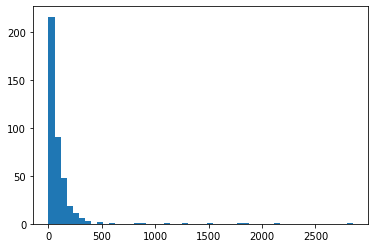

In [27]:
plt.figure()
plt.hist(mangaHIall['WF50_to_MTot-norm'], bins = 50)

plt.show()

### Writing the data into a new file

In [21]:
mangaHIall.write('input/mangaHIall_nearestDistances.txt', format = 'ascii.commented_header', overwrite = True)